Na tarefa anterior se fixo unha pequena base de datos con caras. Neste caso se trata de facer unha aplicación de consola que cargue esa base de datos e tente identificar as caras presentes.

Á saída debera escribir os nomes das persoas que foi capaz de identificar e o número de persoas que non foi capaz de poñerlle nome.

In [2]:
import dlib
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
import pandas as pd
import csv




In [17]:

try:

    df = pd.read_csv('caras_conocidas.csv')

    # revertimos lo que habiamos hecho en la tarea anterior, para poder convertilo en array 
    df["vector"] = df.apply(lambda row: np.array(row['fingerprint'].split(',')).astype(np.float64), axis=1)
    display(df.head())
except FileNotFoundError:
    print("No encontrado")


,nome,fingerprint,vector
0,Nicki nicole,"-0.1250859498977661,0.029452471062541008,0.007...","[-0.1250859498977661, 0.029452471062541008, 0...."


Pido al usuario la foto nueva, donde hay mas personas, 


In [18]:

try:
    Tk().withdraw()
    path = filedialog.askopenfilename(
        title="Choose an image",
        filetypes=[("Imágenes", "*.jpg *.png *.jpeg")]
    )
except Exception as e:
    print("Can't open the file")
    raise e

if not path:
    print("You don't choose the image")
    exit()

image = cv2.imread(path)
image_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

if image is None:
    print("This type of image can't be load")
    exit()



In [19]:

predictor_path ="../../docs/dlib/shape_predictor_5_face_landmarks.dat"
face_rec_model_path = "../../docs/dlib/dlib_face_recognition_resnet_model_v1.dat"


detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)
facerec = dlib.face_recognition_model_v1(face_rec_model_path)


known_face_encodings = []
known_face_names = []

Detectar caras en la foto nueva

In [20]:
# Detectamos caras na foto nova
dets = detector(image_color, 1)
print(f"Caras detectadas {len(dets)}")

nomes_identificados = []
contador_descoñecidos = 0
tolerancia = 0.6  # recordar cuanto menos se le ponga a este para parameto mas extrico

Caras detectadas 2


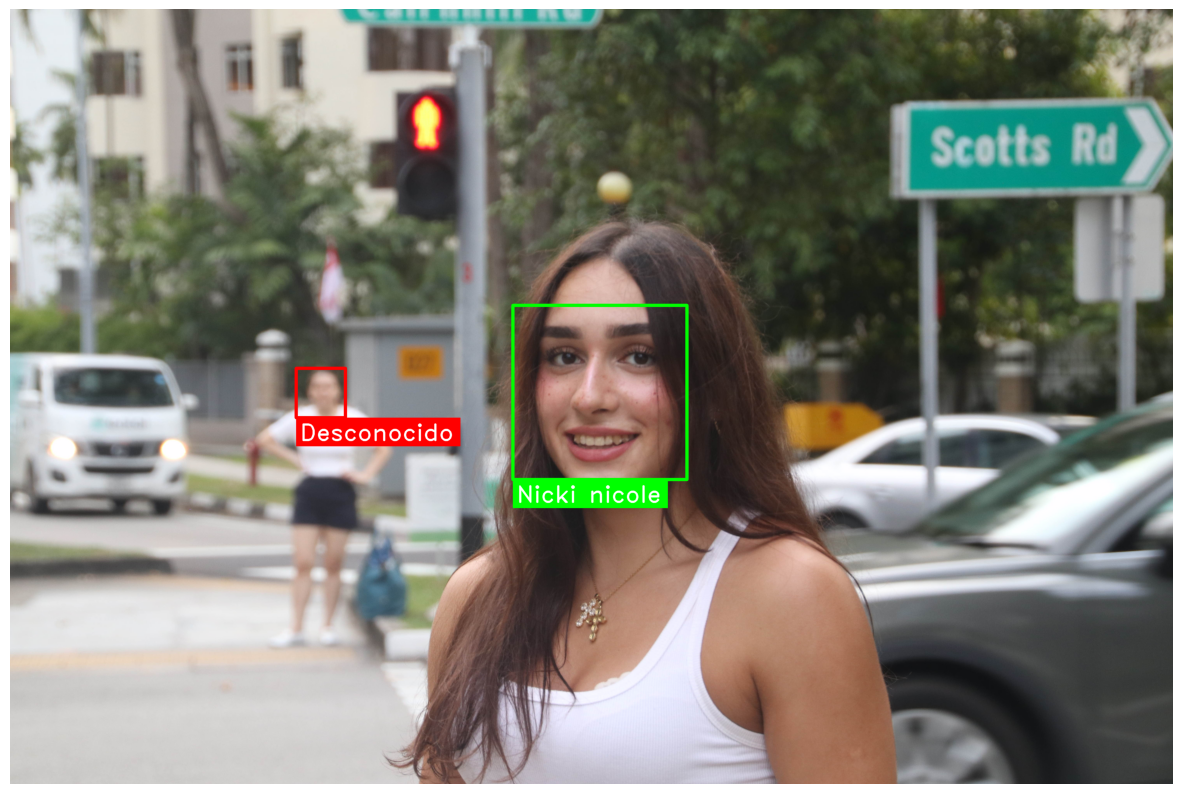

In [26]:
img_final = image_color.copy()

grosor_cuadro = 15      
tamano_letra = 4.0
grosor_letra = 5
padding = 50

nomes_identificados = []
contador_descoñecidos = 0
h_img, w_img, _ = img_final.shape

for k, d in enumerate(dets):
    
    shape = sp(image_color, d)
    face_descriptor = np.array(facerec.compute_face_descriptor(image_color, shape))
    
    atopo_match = False
    nome_match = "Desconocido"
    menor_distancia = 100 
    
    for index, row in df.iterrows():
        vector_db = row['vector']
        nome_db = row['nome']
        distancia = np.linalg.norm(face_descriptor - vector_db)
        
        if distancia < tolerancia:
            if distancia < menor_distancia:
                menor_distancia = distancia
                nome_match = nome_db
                atopo_match = True
    
    if atopo_match:
        nomes_identificados.append(nome_match)
        color_box = (0, 255, 0) 
    else:
        contador_descoñecidos += 1
        color_box = (255, 0, 0) 

    
    x1 = max(0, d.left() - padding)
    y1 = max(0, d.top() - padding)
    x2 = min(w_img, d.right() + padding)
    y2 = min(h_img, d.bottom() + padding)
    
    
    cv2.rectangle(img_final, (x1, y1), (x2, y2), color_box, grosor_cuadro)
    
    font = cv2.FONT_HERSHEY_DUPLEX
    (text_width, text_height), baseline = cv2.getTextSize(nome_match, font, tamano_letra, grosor_letra)
    
    cv2.rectangle(img_final, 
                (x1, y2), 
                (x1 + text_width + 50, y2 + text_height + 60),
                color_box, 
                cv2.FILLED)
    
    cv2.putText(img_final, 
                nome_match, 
                (x1 + 20, y2 + text_height + 30), 
                font, 
                tamano_letra, 
                (255, 255, 255), 
                grosor_letra,
                cv2.LINE_AA)

plt.figure(figsize=(15, 15)) 
plt.imshow(img_final)
plt.axis('off')
plt.show()